# Homework 3

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-04-14

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

- the corporate and government bonds symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`, containing EOD price data as of 2024-12-13.
- the corporate bonds call schedule file `call_schedules`.


-----------------------------------------------------------
# Problem 1: Different types of bond yields and durations (fixed income recap)

### A. Continuously compounded (exponential) yields
In Lecture 1 we introduced the continuously compounded (exponential) yield $y$, used to discount bonds with arbitrary/generic cashflows 

\begin{align}
\{c_i ,T_i\}_{i=1..n}
\end{align} 

via the valuation formula

\begin{align}
B(y)=\sum_{i=1}^{n}c_{i}\cdot e^{-T_{i}\cdot y}
\end{align}

We then defined the bond duration $D$ (also called Macaulay duration) as the log-sensitivity of the bond price with respect to the exponential yield $y$:

\begin{align}
\frac{\partial B}{\partial y} = -B \cdot D
\end{align}

and showed that $D$ can be expressed as a weighted sum of time to maturities $T_i$

\begin{align}
D=\frac{\sum_{i=1}^{n}T_i \cdot c_{i}\cdot e^{-T_{i}\cdot y}}{\sum_{i=1}^{n}c_{i}\cdot e^{-T_{i}\cdot y}} = \sum_{i=1}^{n}T_i \cdot w_i
\end{align}

### B. Discretely compounded yields
For bonds with n regular coupon payment (coupon frequency = n), it is natural to define the discretely compounded yields $y_n$ (corresponding to the coupon frequency n):


\begin{align}
\left(1+\frac{y_{n}}{n}\right)^n=e^y
\end{align}

The most common cases in US fixed income markets are:

1. Semi-annual coupon frequency (e.g fixed rate USD bonds): the semi-annual yield $y_{sa} = y_2$ satisfies the formula

\begin{align}
\left(1+\frac{y_{sa}}{2}\right)^2=e^y
\end{align}

2. Quarterly coupon frequency (e.g floating rate USD bonds): the quarterly yield $y_{qt} = y_4$ satisfies the formula

\begin{align}
\left(1+\frac{y_{qt}}{2}\right)^4=e^y
\end{align}


3. Monthly coupon frequency (e.g USD loans): the monthly yield $y_{mo} = y_{12}$ satisfies the formula

\begin{align}
\left(1+\frac{y_{mo}}{12}\right)^{12}=e^y
\end{align}

As a general rule, discretely compunded yields are descreasing in the coupon frequency n:

\begin{align}
y_{sa} \geq y_{qt} \geq y_{mo} \geq y_{\infty} = y
\end{align}

### C. Modified duration
For a bond with n regular coupon payments, the modified duration $D_{mod}$ is defined as the log-sensitivity of the bond price with respect to the discretely compounded yield $y_n$:

\begin{align}
\frac{\partial B}{\partial y_{n}} = -B \cdot D_{mod}
\end{align}


In practice, when fixed income market participants talk about yields, DV01s and durations, they imply the type based on the cashflow frequency of the underlying instrument.

## To do:

### a. For fixed rate semi-annual USD bonds (frequency = 2), show that

\begin{align}
D_{mod} = D \cdot \left(1+\frac{y_{sa}}{2} \right)^{-1}
\end{align}


### b. In general, for bonds with n regular coupon payments (frequency = n), show that

\begin{align}
D_{mod} = D \cdot \left(1+\frac{y_{n}}{n} \right)^{-1}
\end{align}


### Solution

First, we observe that

\begin{align}
y = n \cdot \log \left(1 + \frac{y_n}{n} \right) 
\end{align}

hence

\begin{align}
\frac{\partial y}{\partial y_{n}} = \left(1+\frac{y_{n}}{n} \right)^{-1}.
\end{align}


Using the definition of $D_{mod}$ and the chain rule, we obtain

\begin{align}
D_{mod} = - \frac{1}{B} \cdot \frac{\partial B}{\partial y_{n}} 
\end{align}


\begin{align}
= - \frac{1}{B} \cdot \frac{\partial B}{\partial y} \cdot \frac{\partial y}{\partial y_{n}}
\end{align}

\begin{align}
= D \cdot \frac{\partial y}{\partial y_{n}}
\end{align}

\begin{align}
= D \cdot \left(1+\frac{y_{n}}{n} \right)^{-1}.
\end{align}

This covers a., as a special case for n = 2.


-----------------------------------------------------------
# Problem 2: Callable bonds: "workout-date" and "yield-to-worst" calculations

In [1]:
import QuantLib as ql
import pandas as pd

# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

## a. Load and explore the call schedules dataframe

Load the `call_schedules` Excel file into a dataframe. It contains call schedules for fixed-rate, callable corporate bonds.

For each bond in the dataframe, compute `num_call_dates`, the total number of outstanding calls.

In [2]:
call_schedules_df = pd.read_excel('data/call_schedules.xlsx')
display(call_schedules_df.head())

call_schedules_count_df = call_schedules_df[['isin', 'call_date']].groupby(['isin']).count()
call_schedules_count_df.columns = ['num_call_dates']
display(call_schedules_count_df.describe())


,isin,figi,call_date,call_price
0,US345397D427,BBG01GXL4DP0,2030-03-10,100
1,US345397D591,BBG01K0V0QY0,2028-10-07,100
2,US345397E748,BBG01MVPX165,2027-04-17,100
3,US345397G313,BBG01QLGYZV3,2031-09-05,100
4,US34540TB359,BBG019LXFLX4,2026-03-20,100


,num_call_dates
count,340.000000
mean,13.088235
std,33.128932
min,1.000000
25%,1.000000
50%,1.000000
75%,7.000000
max,186.000000


## b. Load the bond symbology dataframe and extend it with the fixed-rate callable corporate bond details from 1a.

Load the `bond_symbology` Excel file into a dataframe and keep only the fixed-rate callable bonds from 1a.

Extend the dataframe with the column computed in 1a:

| num_call_dates |
|----------|

In [3]:
corp_symbology_df = pd.read_excel('data/bond_symbology.xlsx')
corp_symbology_df = corp_symbology_df[(corp_symbology_df['cpn_type'] == 'FIXED') & 
                                    (corp_symbology_df['mty_typ'] == 'CALLABLE')]

# combined_df
combined_df = corp_symbology_df.merge(call_schedules_count_df, how='right', on=['isin'])
display(combined_df.head())


,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,cpn_first,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,num_call_dates
0,AAPL,Corp,BBG00C7QBCQ1,US037833BW97,US91282CLW90,AAPL 4 1/2 02/23/36,APPLE INC,GLOBAL,4.50,FIXED,...,2016-08-23,2016-02-23,2036-02-23,CALLABLE,Sr Unsecured,1250.0,US,USD,ACTV,1
1,AAPL,Corp,BBG00C7QBG91,US037833BX70,US912810UF39,AAPL 4.65 02/23/46,APPLE INC,GLOBAL,4.65,FIXED,...,2016-08-23,2016-02-23,2046-02-23,CALLABLE,Sr Unsecured,4000.0,US,USD,ACTV,1
2,AAPL,Corp,BBG00DHQX240,US037833BZ29,US91282CLY56,AAPL 2.45 08/04/26,APPLE INC,GLOBAL,2.45,FIXED,...,2017-02-04,2016-08-04,2026-08-04,CALLABLE,Sr Unsecured,2250.0,US,USD,ACTV,1
3,AAPL,Corp,BBG00DHQX9M5,US037833CD08,US912810UF39,AAPL 3.85 08/04/46,APPLE INC,GLOBAL,3.85,FIXED,...,2017-02-04,2016-08-04,2046-08-04,CALLABLE,Sr Unsecured,2000.0,US,USD,ACTV,1
4,AAPL,Corp,BBG00FXTSMV3,US037833CH12,US912810UF39,AAPL 4 1/4 02/09/47,APPLE INC,GLOBAL,4.25,FIXED,...,2017-08-09,2017-02-09,2047-02-09,CALLABLE,Sr Unsecured,1000.0,US,USD,ACTV,1


## c. Add a function to compute "yield-to-maturity",  "yield-to-worst" and "workout date" for a fixed-rate callable bond

Quick recap: given the current market price, the issuer is expected to call a callable bond on the call date corresponding to lowes "yield to call date".

This corresponds to the best possible scenario from the point of view of the issuer exercising the call option (and the worst possible scenario from the point of view of the bond investor).

The lowest possible yield on a call date is called the "yield-to-worst" and the corresponding call date (on which the issuer is expected to call the bond) is called the "workout date". 

Keep in mind that the "workout date" could be the bond maturity date, in which case "yield-to-worst" = "yield-to-maturity".

To do: for a callable fixed-rate bond with known symbology (reference data) and call schedules dataframes, create a function that takes the clean market price as an input and returns the "yield-to-maturity, "yield-to-worst and "workout date".

1. Compute the yield to maturrity first.
2. For each  call date, create the corresponding "call scenario" bond object (using the call date as maturity).
3. Compute the corresponding "call scenario yield" (using the bond clean market price as input).
4. Identify "workout date" and "yield-to-worst".


In [4]:
def calc_yield_to_worst(
            details: dict,
            pc_schedule: pd.DataFrame,
            bond_clean_price: float,
            calc_date: ql.Date):
    '''Computes yield-to-worst and workout date for fixed rate callable bonds.
    '''    
    
    maturity_date =  details['maturity']    

    # create base case bond (to maturity) and compute yield_to_maturity
    bond_object = create_bond_from_symbology(details)
    # yield_to_maturity = details['yield_to_maturity']
    yield_to_maturity = bond_object.bondYield(bond_clean_price, bond_object.dayCounter(), ql.Compounded, ql.Semiannual) * 100

    # start with maturity and yield_to_maturity (base case)
    workout_date = maturity_date
    yield_to_worst = yield_to_maturity
    
    # keep schedules for used bond only
    used_pc_schedule = pc_schedule[pc_schedule['isin'] == details['isin']]
    
    for _, row in used_pc_schedule.iterrows():
        call_date = row['call_date']
        if get_ql_date(call_date) > calc_date:
            
            # Create a call scenario details df
            call_scenario_details = details.copy()
            call_scenario_details['maturity'] = row['call_date']
            call_scenario_bond_object = create_bond_from_symbology(call_scenario_details)
            
            # scenario_yield
            call_scenario_yield = call_scenario_bond_object.bondYield(bond_clean_price, call_scenario_bond_object.dayCounter(), ql.Compounded, ql.Semiannual) * 100
                                            
            # Update yield_to_worst and workout_date if needed
            if call_scenario_yield < yield_to_worst:
                print('Found new workout date:', details['isin'], workout_date, call_date, yield_to_worst, call_scenario_yield)
                
                yield_to_worst = call_scenario_yield
                workout_date = call_date
                
    return yield_to_maturity, yield_to_worst, workout_date


## d. Compute "workout dates" and "yields-to-worst" for all Oracle fixed-rate callable bonds

Load the `bond_market_prices_eod` Excel file into a dataframe, which contains marktet quotes as of 2024-12-13.

For each Oracle fixed-rate callable bond in the symbology dataframe (ticker = 'ORCL'):
- 1. Compute the yield to maturity (using clean market prices)

- 2. Use the function from 1c to compute "workout date" and "yield-to-worst".

Extend the symbology dataframe with the following columns:


| clean_price |  yield_to_maturity | yield_to_worst | workout_date |
|----------|-------------|-------|-------------|

Which ORCL callable bonds are expected to be called early, i.e. have workout_date < maturity? There should be 3 of them!


In [5]:
# market_prices_df
market_prices_df = pd.read_excel('data/bond_market_prices_eod.xlsx')
# market_prices_df.set_index('figi',inplace=True)

# combined_df: filter for ORCL bonds only
combined_df = corp_symbology_df[corp_symbology_df['ticker'] == 'ORCL'].merge(market_prices_df, how='inner', on=['class', 'ticker', 'isin', 'figi'])
# combined_df.set_index('figi',inplace=True)

# add yield_to_maturity
combined_df['clean_price'] = (combined_df['bidPrice'] + combined_df['askPrice'])/2

# add dummy yield_to_maturity, yield_to_worst and workout_date columns, to be populated later
combined_df['yield_to_maturity'] = 0.0
combined_df['yield_to_worst'] = 0.0
combined_df['workout_date'] = combined_df['maturity']

display(combined_df.head())


,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,date,bidPrice,askPrice,accrued,bidYield,askYield,clean_price,yield_to_maturity,yield_to_worst,workout_date
0,ORCL,Corp,BBG006R54KG9,US68389XAV73,US91282CLW90,ORCL 4.3 07/08/34,ORACLE CORP,GLOBAL,4.300,FIXED,...,2024-12-13,92.948,93.348,1.8870,5.247,5.191,93.1480,0.0,0.0,2034-07-08
1,ORCL,Corp,BBG006R54KN1,US68389XAW56,US912810UF39,ORCL 4 1/2 07/08/44,ORACLE CORP,GLOBAL,4.500,FIXED,...,2024-12-13,85.563,86.309,1.9750,5.737,5.667,85.9360,0.0,0.0,2044-07-08
2,ORCL,Corp,BBG008LS4TV5,US68389XBD66,US91282CMA61,ORCL 3 1/4 05/15/30,ORACLE CORP,GLOBAL,3.250,FIXED,...,2024-12-13,92.085,92.428,0.2795,4.933,4.857,92.2565,0.0,0.0,2030-05-15
3,ORCL,Corp,BBG008LS4VN9,US68389XBE40,US91282CLW90,ORCL 3.9 05/15/35,ORACLE CORP,GLOBAL,3.900,FIXED,...,2024-12-13,88.736,89.187,0.3365,5.322,5.261,88.9615,0.0,0.0,2035-05-15
4,ORCL,Corp,BBG008LS4X46,US68389XBF15,US912810UF39,ORCL 4 1/8 05/15/45,ORACLE CORP,GLOBAL,4.125,FIXED,...,2024-12-13,80.236,80.918,0.3550,5.787,5.721,80.5770,0.0,0.0,2045-05-15


In [6]:
for row_index, row in combined_df.iterrows():
        
    details = row.to_dict()
        
    bond_clean_price = details['clean_price']
    
    yield_to_maturity, yield_to_worst, workout_date = calc_yield_to_worst(details, call_schedules_df, bond_clean_price, calc_date)
    
    combined_df.loc[row_index, 'yield_to_maturity'] = yield_to_maturity
    combined_df.loc[row_index, 'yield_to_worst'] = yield_to_worst
    combined_df.loc[row_index, 'workout_date'] = workout_date
    
  
# Which ORCL callable bonds are expected to be called early, i.e. have workout_date < maturity? There should be 3 of them!
print('Bonds with workout_date < maturity (early call):')
display(combined_df[combined_df['maturity'] != combined_df['workout_date']][['isin', 'security', 'maturity', 'clean_price', 'yield_to_maturity', 'yield_to_worst', 'workout_date']])

Found new workout date: US68389XCH61 2029-11-09 00:00:00 2029-09-09 00:00:00 4.8846540451049805 4.845641074661292
Found new workout date: US68389XCJ28 2032-11-09 00:00:00 2032-08-09 00:00:00 5.135895729064941 5.107214927673341
Found new workout date: US68389XCK90 2052-11-09 00:00:00 2052-05-09 00:00:00 5.8574152469635 5.850478696823119
Bonds with workout_date < maturity (early call):


,isin,security,maturity,clean_price,yield_to_maturity,yield_to_worst,workout_date
23,US68389XCH61,ORCL 6.15 11/09/29,2029-11-09,105.4465,4.884654,4.845641,2029-09-09
24,US68389XCJ28,ORCL 6 1/4 11/09/32,2032-11-09,107.1520,5.135896,5.107215,2032-08-09
25,US68389XCK90,ORCL 6.9 11/09/52,2052-11-09,114.2355,5.857415,5.850479,2052-05-09


-----------------------------------------------------------
# Problem 3: Risk & Scenario analysis for a fixed rate corporate bond (yield model)
## Use the QuantLib Basic notebook (or previous homeworks) as templates.

## a. Create generic fixed-rate corporate bond
Fix the calculation date as of December 13 2024 and use a coupon of 5% and a maturity of 10 years (December 13 2034).

Display the fixed rate bond cashflows.

In [7]:
# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

In [8]:
# bond_details
test_bond_details = {'class': 'Corp',
                'start_date': '2024-12-13', 
                'acc_first': '2024-12-13', 
                'maturity': '2034-12-13', 
                'coupon': 5,
                'dcc' : '30/360',
                'days_settle' : 1}

# Use create_bond_from_symbology() to create the bond from the bond details dictionary
test_fixed_rate_bond = create_bond_from_symbology(test_bond_details)

test_fixed_rate_bond_cashflows_df = get_bond_cashflows(test_fixed_rate_bond, calc_date)
print(test_fixed_rate_bond_cashflows_df)

           CashFlowDate  CashFlowYearFrac  CashFlowAmount
0       June 13th, 2025               0.5             2.5
1   December 13th, 2025               1.0             2.5
2       June 13th, 2026               1.5             2.5
3   December 13th, 2026               2.0             2.5
4       June 13th, 2027               2.5             2.5
5   December 13th, 2027               3.0             2.5
6       June 13th, 2028               3.5             2.5
7   December 13th, 2028               4.0             2.5
8       June 13th, 2029               4.5             2.5
9   December 13th, 2029               5.0             2.5
10      June 13th, 2030               5.5             2.5
11  December 13th, 2030               6.0             2.5
12      June 13th, 2031               6.5             2.5
13  December 13th, 2031               7.0             2.5
14      June 13th, 2032               7.5             2.5
15  December 13th, 2032               8.0             2.5
16      June 1

## b. Compute the bond price, DV01, duration and convexity (analytic method).

Assume that the market yield of the bond is 6%. Compute the bond price, DV01, duration and convexity, using the analytic method.

In [9]:
# test_bond_yield of 6%
test_bond_yield = 6

# test_bond_clean_price
test_bond_clean_price = test_fixed_rate_bond.cleanPrice(test_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)
test_bond_dirty_price = test_fixed_rate_bond.dirtyPrice(test_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)

# Compute analytical dv01, duration and convexity
test_bond_yield_rate = ql.InterestRate(test_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)
test_bond_duration = ql.BondFunctions.duration(test_fixed_rate_bond, test_bond_yield_rate)
test_bond_convexity = ql.BondFunctions.convexity(test_fixed_rate_bond, test_bond_yield_rate)
test_bond_dv01 = test_bond_duration * test_bond_dirty_price / 100

print('test_bond_clean_price:', round(test_bond_clean_price, 2))
print('test_bond_dirty_price:', round(test_bond_dirty_price, 2))
print('test_bond_dv01:', round(test_bond_dv01, 2))
print('test_bond_duration:', round(test_bond_duration, 2))
print('test_bond_convexity:', round(test_bond_convexity, 2))



test_bond_clean_price: 92.57
test_bond_dirty_price: 92.61
test_bond_dv01: 7.09
test_bond_duration: 7.66
test_bond_convexity: 71.66


## c. Scenario bond prices: "re-pricing" vs "second-order approximations"

Compute the scenario bond prices on the following scenario yield grid: [from 1% to 11% in steps of 0.5%]

Compute the second-order scenario price approximations using duration and convexity sensitivities (formula 13 from Lecture 1).

\begin{align}
\Delta B(y) = B\left(y+\Delta y\right)-B\left(y\right)\approx B\cdot\left[- D\cdot\Delta y+\frac{1}{2}\cdot\Gamma\cdot\left(\Delta y\right)^{2}\right]
\end{align}

Plot the scenario prices (Y-axis) vs yieds (X-axis), for both the "re-pricing" and "second-order approximations" method.

Here we are using formula [13] from Lecture 1, which gives us the second-order price approximation via duration/convexity (second order Taylor expansion in yield parameter).

We implement formula [13] into the `calc_second_order_price_change(...)` function, taking into account that $B(y)$ is the dirty bond price.


    ScenYields  ScenPrices  ApproxPrices
0          1.0       137.9         136.3
1          1.5       132.4         131.2
2          2.0       127.0         126.2
3          2.5       122.0         121.4
4          3.0       117.2         116.8
5          3.5       112.6         112.4
6          4.0       108.2         108.1
7          4.5       104.0         104.0
8          5.0       100.0         100.0
9          5.5        96.2          96.2
10         6.0        92.6          92.6
11         6.5        89.1          89.1
12         7.0        85.8          85.8
13         7.5        82.6          82.7
14         8.0        79.6          79.7
15         8.5        76.7          76.9
16         9.0        74.0          74.3
17         9.5        71.4          71.8
18        10.0        68.9          69.5
19        10.5        66.5          67.4
20        11.0        64.2          65.4


Text(0.5, 0, 'Yield')

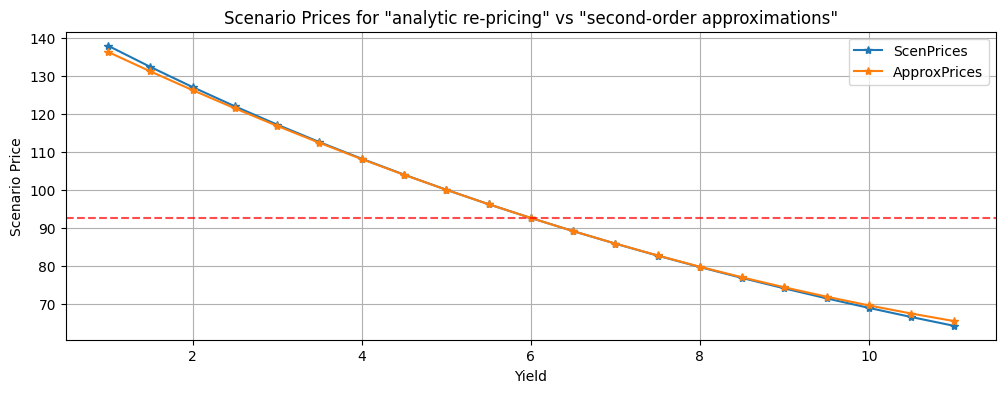

In [10]:
def calc_second_order_price_change(dirty_price, yield_diff, duration, convexity):
    return dirty_price * (- yield_diff * duration + 0.5 * yield_diff*yield_diff*convexity)

# bond_yield_grid : yield grid [from 1% to 11% in steps of 0.5%]    
bond_yield_grid = [y for y in np.arange(1, 11.5, 0.5)]

# scenario_prices
scenario_prices = [round(test_fixed_rate_bond.cleanPrice(y/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual), 3) for y in bond_yield_grid]

# second_order_approx_prices
second_order_approx_prices = [round(test_bond_clean_price + calc_second_order_price_change(test_bond_dirty_price, (y - test_bond_yield) / 100, test_bond_duration, test_bond_convexity), 2) 
                                   for y in bond_yield_grid]

# plot bond_scennarios_df
bond_scenarios_df = pd.DataFrame(data={'ScenYields': bond_yield_grid, 'ScenPrices': scenario_prices, 'ApproxPrices': second_order_approx_prices})
print(bond_scenarios_df.round(1))

# Plot Scenario Prices for "analytic re-pricing" vs "second-order approximations
plt = bond_scenarios_df.plot(x='ScenYields', y=['ScenPrices', 'ApproxPrices'], grid=True, style='-*', title='Scenario Prices for "analytic re-pricing" vs "second-order approximations"', figsize=(12,4))
plt.axhline(test_bond_clean_price, color='red', linestyle='--', alpha=0.7)
plt.set_ylabel('Scenario Price')
plt.set_xlabel('Yield')


## d. Extreme event scenarios

Compute and show the scenario bond price for a bond yield of 15% (extreme event scenario).

Compute and show the second-order scenario price approximation in the extreme event scenario.

Compute and show the analytic DV01, duration and convexity in the extreme event scenario.

How accurate is the second-order approximation (Taylor expansion using duration and convexity) in the extreme event case, and why?

In [11]:
extreme_event_bond_yield = 15

# Compute analytical vs. second order approximation extreme event prices
extreme_event_bond_clean_price = round(test_fixed_rate_bond.cleanPrice(extreme_event_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual), 3)
extreme_event_second_order_approx_price = round(test_bond_clean_price + calc_second_order_price_change(test_bond_dirty_price, (extreme_event_bond_yield - test_bond_yield) / 100, test_bond_duration, test_bond_convexity), 2) 

# Compute analytical dv01, duration and convexity for extreme event scenario
extreme_event_bond_yield_rate = ql.InterestRate(extreme_event_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)
extreme_event_bond_duration = ql.BondFunctions.duration(test_fixed_rate_bond, extreme_event_bond_yield_rate)
extreme_event_bond_convexity = ql.BondFunctions.convexity(test_fixed_rate_bond, extreme_event_bond_yield_rate)

extreme_event_bond_dirty_price = test_fixed_rate_bond.dirtyPrice(extreme_event_bond_yield/100, test_fixed_rate_bond.dayCounter(), ql.Compounded, ql.Semiannual)
extreme_event_bond_dv01 = extreme_event_bond_duration * extreme_event_bond_dirty_price / 100

print('extreme_event_scenario_price:', extreme_event_bond_clean_price)
print('extreme_event_approx_price:', extreme_event_second_order_approx_price)
print('extreme_event_approx_error:', round(extreme_event_second_order_approx_price - extreme_event_bond_clean_price, 2))         

print('extreme_event_bond_dv01:', round(extreme_event_bond_dv01, 2))
print('extreme_event_bond_duration:', round(extreme_event_bond_duration, 2))
print('extreme_event_bond_convexity:', round(extreme_event_bond_convexity, 2))



extreme_event_scenario_price: 49.045
extreme_event_approx_price: 55.62
extreme_event_approx_error: 6.57
extreme_event_bond_dv01: 3.16
extreme_event_bond_duration: 6.44
extreme_event_bond_convexity: 55.34


The second-order scenario price approximations (second order quadratic Taylor approximation using duration and convexity) is only accurate locally, for relatively small yield changes. It is not accurate for large yield changes, as we can see above.

-----------------------------------------------------------
# Problem 4: Perpetual bonds
## a. Price a fixed rate perpetual bond
We are interested in a fixed rate perpetual bond (infinite maturity) on a face notional of $100 and semi-annual coupon c.

Assuming that the bond has a known continuously componded yield of y, what is the price of the perpetual bond (assume T+0 settlement and zero accrued)?

Use the definition of the semi-annual yield: $y_{sa} = 2 \cdot \left(e^{\frac{y}{2}}-1 \right)$.

You can use following sympy code (implementing Formula 5 from Session 1) as a starting point.

In [12]:
# import libraries
import sympy as sp

# define fixed rate bond specs as symbolic variables
T = sp.symbols('T')
c = sp.symbols('c')
y = sp.symbols('y')

# define symbolic equation for generic fixed rate bond pv
bond_pv_eq =  1 + (c/2  / (sp.exp(y/2) - 1) - 1 )* (1 - sp.exp(-T*y))
print('Analytic formula for bond_pv:', bond_pv_eq)
display(bond_pv_eq)

Analytic formula for bond_pv: (1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1


(1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1

We start with the formula for pricing a risky fixed rate bond on a face of 100%, derived in Lecture 1, formulas [4] and [5].

\begin{align}
B_{0}^{T}=B(0,c,T,y)=\sum_{k=1}^{2T}\frac{c}{2}\cdot e^{-k\cdot\frac{y}{2}}+e^{-T\cdot y}
\end{align}

\begin{align}
=1+\frac{\frac{c}{2}-\left(e^{\frac{y}{2}}-1\right)}{e^{\frac{y}{2}}-1}\cdot\left(1-e^{-T\cdot y}\right)
\end{align}

\begin{align}
=1+\frac{c-y_{sa}}{y_{sa}}\cdot\left[1-\left(1+\frac{y_{sa}}{2}\right)^{-2T}\right]
\end{align}

Remember that the the semi-annual yield is given by:  $y_{sa} = 2 \cdot \left(e^{\frac{y}{2}}-1 \right)$.

In the case of the fixed rate perpetual bond, the bond maturity and cashflows extend to "infinity", so the pricing formula simplifies in terms of $y_{sa}$ to

\begin{align}
B_{0}^{\infty}=B(0,c,\infty,y)=\sum_{k=1}^{\infty}\frac{c}{2}\cdot e^{-k\cdot\frac{y}{2}} =  \frac{c}{2 \cdot \left(e^{\frac{y}{2}}-1 \right)}=\frac{c}{y_{sa}},
\end{align}


To obtain the fair price on a face of $100, one has to multiply the formula above by 100:
\begin{align}
B_{0}^{\infty}(100) =  \frac{100 \cdot c}{2 \cdot \left(e^{\frac{y}{2}}-1 \right)} = 100 \cdot \frac{c}{y_{sa}},
\end{align}


## b. Perpetual bonds priced "at par"
For which yield y does the bond trade "at par", i.e. fair value price = $100?

\begin{align}
B_{0}^{\infty}(100)=100 \iff y=2\cdot \ln \left( 1 + \frac{c}{2} \right) \iff y_{sa} = c.
\end{align}


Hence, the perpetual bond trades "at par" if the smi-annual yield $y_{sa}$ matches the semi-annual coupon c (same result as for "regular" fixed rate bonds).

## c. Duration and DV01 for a fixed rate perpetual bond

Compute Duration and DV01 of the perpetual bond.

Use the simpy.diff() function to compute function derivatives.

In [13]:
# define symbolic equations
perpetual_bond_price = c / (sp.exp(y/2) - 1) / 2
print('1. Perpetual bond price (with coupon c):')
display(perpetual_bond_price)

# find first and second order derivatives
first_order_derivative = perpetual_bond_price.diff(y)
print('2. Perpetual bond DV01:')
display(-first_order_derivative)

perpetual_bond_duration =  sp.simplify(- first_order_derivative / perpetual_bond_price)
print('3. Perpetual bond duration:')
display(perpetual_bond_duration)

1. Perpetual bond price (with coupon c):


c/(2*(exp(y/2) - 1))

2. Perpetual bond DV01:


c*exp(y/2)/(4*(exp(y/2) - 1)**2)

3. Perpetual bond duration:


exp(y/2)/(2*exp(y/2) - 2)

Hence, PV01 and duration of a fixed rate perpetual bond are given by

\begin{align}
PV01 = -\frac{\partial B}{\partial y} = -\frac{\partial}{\partial y}\left[\frac{c}{2 \cdot \left( e^{\frac{y}{2}}-1 \right) }\right]=\frac{c \cdot e^{\frac{y}{2}}}{4 \cdot \left( e^{\frac{y}{2}} - 1 \right)^2} = \frac{c \cdot \left( 1 + \frac{y_{sa}}{2} \right) }{y_{sa}^2}
\end{align}


\begin{align}
D = -\frac{1}{B} \cdot \frac{\partial B}{\partial y} = \frac{e^{\frac{y}{2}}}{2 \cdot \left( e^{\frac{y}{2}} - 1 \right)} = \frac{1 + \frac{y_{sa}}{2} }{y_{sa}}.
\end{align}


## d. Convexity of a fixed rate perpetual bond
Compute the convexity of the perpetual bond.

In [14]:
second_order_derivative = sp.simplify(first_order_derivative.diff(y))
print('Second order derivative:')
display(second_order_derivative)

perpetual_bond_convexity =  sp.simplify(second_order_derivative / perpetual_bond_price)
print('Perpetual bond convexity:')
display(perpetual_bond_convexity)


Second order derivative:


-c*((exp(y/2) - 1)*exp(y/2) - 2*exp(y))/(8*(exp(y/2) - 1)**3)

Perpetual bond convexity:


(1 + exp(-y/2))*exp(y)/(4*(-2*exp(y/2) + exp(y) + 1))

Hence, second order derivative and convexity $\Gamma$ of the fixed rate perpetual bond are given by

\begin{align}
\frac{\partial^{2} B}{\partial y^{2}} = \frac{\partial^{2}}{\partial y^{2}}\left[\frac{\frac{c}{2}}{e^{\frac{y}{2}}-1}\right] = \frac{\partial}{\partial y}\left[\frac{c \cdot e^{\frac{y}{2}}}{4 \cdot \left( e^{\frac{y}{2}} - 1 \right)^2} \right] = \frac{c \cdot e^{\frac{y}{2}} \cdot \left(e^{\frac{y}{2}} + 1 \right)}{8 \cdot \left( e^{\frac{y}{2}} - 1 \right)^3}  = \frac{c \cdot \left( 1 + \frac{y_{sa}}{2} \right) \cdot \left( 2 + \frac{y_{sa}}{2} \right)}{y_{sa}^3}
\end{align}

\begin{align}
\Gamma = \frac{1}{B} \cdot \frac{\partial^{2} B}{\partial y^{2}} = \frac{e^{\frac{y}{2}} \cdot \left(e^{\frac{y}{2}} + 1 \right)}{4 \cdot \left( e^{\frac{y}{2}} - 1 \right)^2} =  \frac{\left( 1 + \frac{y_{sa}}{2} \right) \cdot \left( 2 + \frac{y_{sa}}{2} \right)}{y_{sa}^2}. 
\end{align}
